**Script Description:** This script extracts the swc & swc-qf variables from all the individual netCDF4 files and exports a merged CSV file.  

**File Name:** 01_08_Extract_Planet_Data.ipynb

**Date:** 2025

**Created by:** Rob Alamgir

#### Import the relevant packages

In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import netCDF4 as nc
from scipy.spatial import cKDTree

#### Inspect the structire and metadata of one netCDF4 file

In [2]:
file_path = "C:/Data_MSc_Thesis/Planet/SWC_Rob/HO.nc"   # Select a file to inspect
dataset = nc.Dataset(file_path, mode="r")               # Open the NetCDF file
print(dataset)                                          # Print file summary
dataset.close()                                         # Close the file

<class 'netCDF4.Dataset'>
root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
    dimensions(sizes): var(2), string6(6), timestamp(3286), string13(13), x(18), y(12), source(3), string7(7)
    variables(dimensions): |S1 timestamp(timestamp, string13), float64 x(x), float64 y(y), |S1 source(source, string7), int32 __xarray_dataarray_variable__(source, var, timestamp, y, x), |S1 var(var, string6), int32 spatial_ref()
    groups: 


In [3]:
nc_path = "C:/Data_MSc_Thesis/Planet/SWC_Rob/HO.nc"    # Path to your NetCDF file  
dataset = nc.Dataset(nc_path, "r")                     # Open the NetCDF file

# Check if 'spatial_ref' exists in the file
if "spatial_ref" in dataset.variables:
    spatial_ref = dataset.variables["spatial_ref"]
    print(spatial_ref)  # Print metadata
else:
    print("No spatial reference system found in the file.")
    
dataset.close()                                       # Close the file

<class 'netCDF4.Variable'>
int32 spatial_ref()
    crs_wkt: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
    semi_major_axis: 6378137.0
    semi_minor_axis: 6356752.314245179
    inverse_flattening: 298.257223563
    reference_ellipsoid_name: WGS 84
    longitude_of_prime_meridian: 0.0
    prime_meridian_name: Greenwich
    geographic_crs_name: WGS 84
    horizontal_datum_name: World Geodetic System 1984
    grid_mapping_name: latitude_longitude
    spatial_ref: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST

#### Import the NOBV EC Tower point data

In [4]:
# Load point data
point_data = pd.read_csv("C:/Data_MSc_Thesis/NOBV_Site_Data/NOBV_EC_Tower_Data_Final.csv")
point_data.rename(columns={"EPSG_4326_WGS_84_Longitude_X": "Longitude", "EPSG_4326_WGS_84_Latitude_Y": "Latitude"}, inplace=True)

# Ensure Longitude & Latitude are floats
point_data["Longitude"] = point_data["Longitude"].astype(float)
point_data["Latitude"] = point_data["Latitude"].astype(float)

point_data.head(20)

,Site_no,Location_No,Site_ID,Longitude,Latitude,EPSG_32631_WGS 84_X_m,EPSG_32631_WGS 84_Y_m,Elevation_m
0,1,1,ALB_MS,5.902334,53.053560,694512.5721,5882167.358,1.1
1,2,1,ALB_RF,5.904631,53.053385,694667.2798,5882154.181,1.1
2,3,2,AMM,5.903505,53.031374,694691.0225,5879703.421,1.1
3,4,2,AMR,5.902991,53.032245,694652.6416,5879798.861,1.1
4,5,3,ANK_PT,5.097471,52.253916,643168.4419,5791352.667,-1.4
5,6,4,ASD_MP,4.739599,52.475256,618150.9361,5815322.395,-2.0
6,7,5,BUO,5.873570,53.100143,692377.3494,5887269.906,-1.3
7,8,5,BUW,5.862276,53.096044,691639.6611,5886783.816,-1.0
8,9,6,CAM,6.579765,53.154907,739334.9552,5895489.504,0.5
9,10,7,DEM,4.946176,52.201298,632999.5877,5785212.722,-2.0


#### Define the function which extracts the scw and swc-qf for each location

In [5]:
df_final = pd.DataFrame()           # Global DataFrame to store results

def process_netcdf(nc_file, selected_sites):
    global df_final                 # Use the global dataframe to store all results
    ds = xr.open_dataset(nc_file)   # Load NetCDF file
    ds["timestamp"] = pd.to_datetime(ds["timestamp"].values, format="%Y%m%dT%H%M")   # Convert timestamp to datetime

    # Extract coordinate grid from NetCDF
    x_coords = ds["x"].values                                                 # Longitudes
    y_coords = ds["y"].values                                                 # Latitudes
    grid_points = np.array(np.meshgrid(x_coords, y_coords)).T.reshape(-1, 2)  # Flatten grid
    
    tree = cKDTree(grid_points)     # Build a KDTree for fast spatial lookup
    if "Matched_X" not in selected_sites or "Matched_Y" not in selected_sites:
        raise ValueError("Selected sites DataFrame must contain 'Matched_X' and 'Matched_Y' columns.")

    data_var = ds["__xarray_dataarray_variable__"]  # Main data variable
    filtered_data = data_var.sel(source="AMSR2-C", var=["swc", "swc-qf"])   # Extract SWC & swc-qf data

    df_list = []
    for _, row in selected_sites.iterrows():
        matched_x, matched_y = row["Matched_X"], row["Matched_Y"]
        site_id = row["Site_ID"]

        # Find the nearest grid point
        x_idx = np.abs(x_coords - matched_x).argmin()
        y_idx = np.abs(y_coords - matched_y).argmin()

        # Select the nearest SWC values
        swc_values = filtered_data.sel(x=x_coords[x_idx],
                                       y=y_coords[y_idx],
                                       method="nearest")

        # Extract timestamps and SWC values
        timestamps = swc_values["timestamp"].values
        swc_data = swc_values.values  # Shape (2, N)

        # Append extracted values row by row
        for i in range(len(timestamps)):
            df_list.append([
                site_id, "AMSR2-C", timestamps[i], matched_x, matched_y,
                swc_data[0, i],  # swc
                swc_data[1, i]   # swc-qf
            ])

    # Convert list to DataFrame
    df_swc = pd.DataFrame(df_list, columns=["Site_ID", "Source", "timestamp", "Matched_X", "Matched_Y", "swc", "swc-qf"])
    df_swc["timestamp"] = pd.to_datetime(df_swc["timestamp"])
    df_swc = df_swc[df_swc["timestamp"].dt.strftime('%H:%M:%S') != '06:00:00']  # Remove invalid timestamps (06:00:00)
    df_swc.reset_index(drop=True, inplace=True)                                 # Reset index 
    df_final = pd.concat([df_final, df_swc], ignore_index=True)                 # Append to final DataFrame

#### Import the netCDF4 files for each location and run the extraction function for that locaiton

In [6]:
# Print the list of NetCDF files
nc_dir = "C:/Data_MSc_Thesis/Planet/SWC_Rob"                     # Set directory path
nc_files = [f for f in os.listdir(nc_dir) if f.endswith(".nc")]  # List all .nc files in the directory
print("NetCDF files found in the directory:")
for file in nc_files:
    print(file)

NetCDF files found in the directory:
ALB.nc
AMM.nc
ANK_PT.nc
ASD_MP.nc
BU.nc
CAM.nc
DEM.nc
HO.nc
ILP_PT.nc
LAW.nc
LD.nc
ONL.nc
WRW.nc
ZEG.nc


In [7]:
ALB_sites = point_data[point_data["Site_ID"].isin(["ALB_MS", "ALB_RF"])].copy()
ALB_sites["Matched_X"], ALB_sites["Matched_Y"] = zip(*ALB_sites.apply(lambda row: [row["Longitude"], row["Latitude"]], axis=1))

nc_file = "C:/Data_MSc_Thesis/Planet/SWC_Rob/ALB.nc"
process_netcdf(nc_file, ALB_sites)

In [8]:
AMM_sites = point_data[point_data["Site_ID"].isin(["AMM", "AMR"])].copy()
AMM_sites["Matched_X"], AMM_sites["Matched_Y"] = zip(*AMM_sites.apply(lambda row: [row["Longitude"], row["Latitude"]], axis=1))

nc_file_2 = "C:/Data_MSc_Thesis/Planet/SWC_Rob/AMM.nc"
process_netcdf(nc_file_2, AMM_sites)

In [9]:
ANK_PT_sites = point_data[point_data["Site_ID"].isin(["ANK_PT"])].copy()
ANK_PT_sites["Matched_X"], ANK_PT_sites["Matched_Y"] = zip(*ANK_PT_sites.apply(lambda row: [row["Longitude"], row["Latitude"]], axis=1))

nc_file_3 = "C:/Data_MSc_Thesis/Planet/SWC_Rob/ANK_PT.nc"
process_netcdf(nc_file_3, ANK_PT_sites)

In [10]:
ASD_MP_sites = point_data[point_data["Site_ID"].isin(["ASD_MP"])].copy()
ASD_MP_sites["Matched_X"], ASD_MP_sites["Matched_Y"] = zip(*ASD_MP_sites.apply(lambda row: [row["Longitude"], row["Latitude"]], axis=1))

nc_file_4 = "C:/Data_MSc_Thesis/Planet/SWC_Rob/ASD_MP.nc"
process_netcdf(nc_file_4, ASD_MP_sites)

In [11]:
BU_sites = point_data[point_data["Site_ID"].isin(["BUO", "BUW"])].copy()
BU_sites["Matched_X"], BU_sites["Matched_Y"] = zip(*BU_sites.apply(lambda row: [row["Longitude"], row["Latitude"]], axis=1))

nc_file_5 = "C:/Data_MSc_Thesis/Planet/SWC_Rob/BU.nc"
process_netcdf(nc_file_5, BU_sites)

In [12]:
CAM_sites = point_data[point_data["Site_ID"].isin(["CAM"])].copy()
CAM_sites["Matched_X"], CAM_sites["Matched_Y"] = zip(*CAM_sites.apply(lambda row: [row["Longitude"], row["Latitude"]], axis=1))

nc_file_6 = "C:/Data_MSc_Thesis/Planet/SWC_Rob/CAM.nc"
process_netcdf(nc_file_6, CAM_sites)

In [13]:
DEM_sites = point_data[point_data["Site_ID"].isin(["DEM"])].copy()
DEM_sites["Matched_X"], DEM_sites["Matched_Y"] = zip(*DEM_sites.apply(lambda row: [row["Longitude"], row["Latitude"]], axis=1))

nc_file_7 = "C:/Data_MSc_Thesis/Planet/SWC_Rob/DEM.nc"
process_netcdf(nc_file_7, DEM_sites)

In [14]:
HO_sites = point_data[point_data["Site_ID"].isin(["HOC", "HOH"])].copy()
HO_sites["Matched_X"], HO_sites["Matched_Y"] = zip(*HO_sites.apply(lambda row: [row["Longitude"], row["Latitude"]], axis=1))

nc_file_8 = "C:/Data_MSc_Thesis/Planet/SWC_Rob/HO.nc"
process_netcdf(nc_file_8, HO_sites)

In [15]:
ILP_PT_sites = point_data[point_data["Site_ID"].isin(["ILP_PT"])].copy()
ILP_PT_sites["Matched_X"], ILP_PT_sites["Matched_Y"] = zip(*ILP_PT_sites.apply(lambda row: [row["Longitude"], row["Latitude"]], axis=1))

nc_file_9 = "C:/Data_MSc_Thesis/Planet/SWC_Rob/ILP_PT.nc"
process_netcdf(nc_file_9, ILP_PT_sites)

In [16]:
LAW_sites = point_data[point_data["Site_ID"].isin(["LAW_MOB", "LAW_MS"])].copy()
LAW_sites["Matched_X"], LAW_sites["Matched_Y"] = zip(*LAW_sites.apply(lambda row: [row["Longitude"], row["Latitude"]], axis=1))

nc_file_10 = "C:/Data_MSc_Thesis/Planet/SWC_Rob/LAW.nc"
process_netcdf(nc_file_10, LAW_sites)

In [17]:
LD_sites = point_data[point_data["Site_ID"].isin(["LDC", "LDH"])].copy()
LD_sites["Matched_X"], LD_sites["Matched_Y"] = zip(*LD_sites.apply(lambda row: [row["Longitude"], row["Latitude"]], axis=1))

nc_file_11 = "C:/Data_MSc_Thesis/Planet/SWC_Rob/LD.nc"
process_netcdf(nc_file_11, LD_sites)

In [18]:
ONL_sites = point_data[point_data["Site_ID"].isin(["ONL"])].copy()
ONL_sites["Matched_X"], ONL_sites["Matched_Y"] = zip(*ONL_sites.apply(lambda row: [row["Longitude"], row["Latitude"]], axis=1))

nc_file_12 = "C:/Data_MSc_Thesis/Planet/SWC_Rob/ONL.nc"
process_netcdf(nc_file_12, ONL_sites)

In [19]:
WRW_sites = point_data[point_data["Site_ID"].isin(["WRW_SR"])].copy()
WRW_sites["Matched_X"], WRW_sites["Matched_Y"] = zip(*WRW_sites.apply(lambda row: [row["Longitude"], row["Latitude"]], axis=1))

nc_file_13 = "C:/Data_MSc_Thesis/Planet/SWC_Rob/WRW.nc"
process_netcdf(nc_file_13, WRW_sites)

In [20]:
ZEG_sites = point_data[point_data["Site_ID"].isin(["ZEG_MOB"])].copy()
ZEG_sites["Matched_X"], ZEG_sites["Matched_Y"] = zip(*ZEG_sites.apply(lambda row: [row["Longitude"], row["Latitude"]], axis=1))

nc_file_14 = "C:/Data_MSc_Thesis/Planet/SWC_Rob/ZEG.nc"
process_netcdf(nc_file_14, ZEG_sites)

In [21]:
df_final = df_final.sort_values(by=["timestamp", "Site_ID"]).reset_index(drop=True)

In [22]:
df_final.info()
#df_final.head(20)
#df_final.tail(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32860 entries, 0 to 32859
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Site_ID    32860 non-null  object        
 1   Source     32860 non-null  object        
 2   timestamp  32860 non-null  datetime64[ns]
 3   Matched_X  32860 non-null  float64       
 4   Matched_Y  32860 non-null  float64       
 5   swc        32860 non-null  float64       
 6   swc-qf     32860 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 1.8+ MB


In [23]:
#df_final.info()
df_final.head(20)
#df_final.tail(20)

,Site_ID,Source,timestamp,Matched_X,Matched_Y,swc,swc-qf
0,ALB_MS,AMSR2-C,2020-01-01 01:30:00,5.902334,53.053560,0.533,-2147483.648
1,ALB_RF,AMSR2-C,2020-01-01 01:30:00,5.904631,53.053385,0.537,-2147483.648
2,AMM,AMSR2-C,2020-01-01 01:30:00,5.903505,53.031374,0.414,-2147483.648
3,AMR,AMSR2-C,2020-01-01 01:30:00,5.902991,53.032245,0.406,-2147483.648
4,ANK_PT,AMSR2-C,2020-01-01 01:30:00,5.097471,52.253916,0.497,-2147483.648
5,ASD_MP,AMSR2-C,2020-01-01 01:30:00,4.739599,52.475256,0.587,-2147483.648
6,BUO,AMSR2-C,2020-01-01 01:30:00,5.873570,53.100143,0.509,-2147483.648
7,BUW,AMSR2-C,2020-01-01 01:30:00,5.862276,53.096044,0.481,-2147483.648
8,CAM,AMSR2-C,2020-01-01 01:30:00,6.579765,53.154907,0.402,-2147483.648
9,DEM,AMSR2-C,2020-01-01 01:30:00,4.946176,52.201298,0.552,-2147483.648


In [24]:
#df_final.info()
df_final.head(20)
#df_final.tail(20)
#df_final.describe()

,Site_ID,Source,timestamp,Matched_X,Matched_Y,swc,swc-qf
0,ALB_MS,AMSR2-C,2020-01-01 01:30:00,5.902334,53.053560,0.533,-2147483.648
1,ALB_RF,AMSR2-C,2020-01-01 01:30:00,5.904631,53.053385,0.537,-2147483.648
2,AMM,AMSR2-C,2020-01-01 01:30:00,5.903505,53.031374,0.414,-2147483.648
3,AMR,AMSR2-C,2020-01-01 01:30:00,5.902991,53.032245,0.406,-2147483.648
4,ANK_PT,AMSR2-C,2020-01-01 01:30:00,5.097471,52.253916,0.497,-2147483.648
5,ASD_MP,AMSR2-C,2020-01-01 01:30:00,4.739599,52.475256,0.587,-2147483.648
6,BUO,AMSR2-C,2020-01-01 01:30:00,5.873570,53.100143,0.509,-2147483.648
7,BUW,AMSR2-C,2020-01-01 01:30:00,5.862276,53.096044,0.481,-2147483.648
8,CAM,AMSR2-C,2020-01-01 01:30:00,6.579765,53.154907,0.402,-2147483.648
9,DEM,AMSR2-C,2020-01-01 01:30:00,4.946176,52.201298,0.552,-2147483.648


In [25]:
df_final = df_final[df_final["swc"] >= 0].reset_index(drop=True)

In [26]:
df_final.info()
#df_final.head(20)
#df_final.tail(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32496 entries, 0 to 32495
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Site_ID    32496 non-null  object        
 1   Source     32496 non-null  object        
 2   timestamp  32496 non-null  datetime64[ns]
 3   Matched_X  32496 non-null  float64       
 4   Matched_Y  32496 non-null  float64       
 5   swc        32496 non-null  float64       
 6   swc-qf     32496 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 1.7+ MB


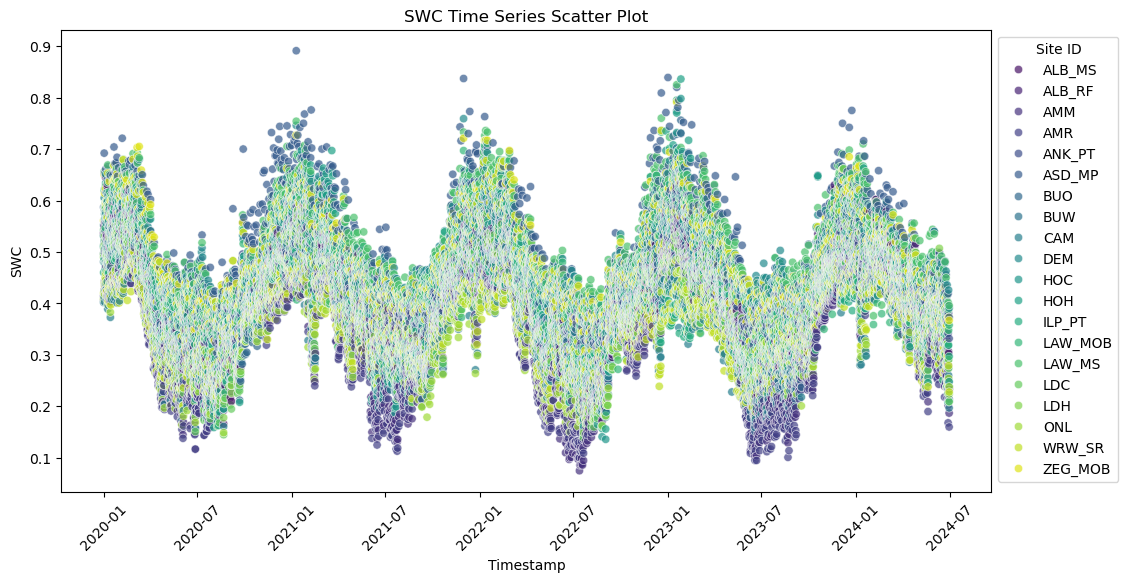

In [27]:
plt.figure(figsize=(12, 6))   
sns.scatterplot(data=df_final, x="timestamp", y="swc", hue="Site_ID", palette="viridis", alpha=0.7)
plt.xlabel("Timestamp")
plt.ylabel("SWC")
plt.title("SWC Time Series Scatter Plot")
plt.xticks(rotation=45)
plt.legend(title="Site ID", bbox_to_anchor=(1, 1))  # Move legend outside
plt.show()                                          # Show plot

#### Export the final dataframe

In [28]:
output_csv = "C:/Data_MSc_Thesis/Planet/Planet_SWC_Extracted.csv"
df_final.to_csv(output_csv, index=False)

print(f"Data has been successfully exported to: {output_csv}")

Data has been successfully exported to: C:/Data_MSc_Thesis/Planet/Planet_SWC_Extracted.csv
